In [1]:
#The Model
'''
    Nearest neighbors is one of the simplest predictive models there is. It makes no mathematical assumptions, and it doesn't require any sort of heavy machinery. THe only things it requires are:
        -Some notion of distance
        -An assumption that points that are close to one another are similar
'''

"\n    Nearest neighbors is one of the simplest predictive models there is. It makes no mathematical assumptions, and it doesn't require any sort of heavy machinery. THe only things it requires are:\n        -Some notion of distance\n        -An assumption that points that are close to one another are similar\n"

In [12]:
from typing import List
from collections import Counter

def raw_majority_vote(labels: List[str]) -> str:
    votes = Counter(labels)
    winner, _ = votes.most_common(1)[0]
    return winner


assert raw_majority_vote(['a', 'b', 'c', 'b']) == 'b'

In [18]:
def majority_vote(labels: List[str]) -> str:
    """Assumes that labels are ordered from nearest to farthest"""
    vote_counts = Counter(labels)
    winner, winner_count = vote_counts.most_common(1)[0]
    num_winners = len([count 
                        for count in vote_counts.values() 
                        if count == winner_count])
    if num_winners == 1:
        return winner                       #unique winner, so return it
    else:
        return majority_vote(labels[:-1])   #try again without the farthest

assert majority_vote(['a', 'b', 'c', 'b', 'a']) == 'b'

In [46]:
#With this function it's easy to create a classifier

from typing import NamedTuple
from scratch.linear_algebra import Vector, distance

class LabeledPoint(NamedTuple):
    point: Vector
    label: str

def knn_classify(k: int,
                    labeled_points: List[LabeledPoint],
                    new_point: Vector) -> str:

    #Order the labeled points from nearest to farthest
    by_distance = sorted(labeled_points, key = lambda lp: distance(lp.point, new_point))

    #Find the labels for the k closest'
    k_nearest_labels = [lp.label for lp in by_distance[:k]]

    #and let them vote
    return majority_vote(k_nearest_labels)

In [29]:
#Example: The Iris Dataset
'''
    The Iris dataset is a staple of ML. It contains a bunch of measurements for 150 flowers representing three species of iris. For each flower we have its petal length, petal width, sepal length, and sepal width, as well as its species.
'''

import requests

data = requests.get("https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data")

with open('iris.csv', 'w') as f:
    f.write(data.text)

In [37]:
'''
    Build a model that can predict the class (that is, the species) from the first four measurements
'''

from typing import Dict
import csv
from collections import defaultdict

def parse_iris_row(row: List[str]) -> LabeledPoint:
    """sepal_length, sepal_width, petal_length, petal_width, class """
    measurements = [float(value) for value in row[:-1]]
    #class is e.g. "Iris-virginica": we just want virginica
    label = row[-1].split("-")[-1]

    return LabeledPoint(measurements, label)

with open('iris.csv') as f:
    reader = csv.reader(f)
    iris_data = [parse_iris_row(row) for row in reader]

#We'll also group just the points by species/label so we can plot them
points_by_species: Dict[str, List[Vector]] = defaultdict(list)
for iris in iris_data:
    points_by_species[iris.label].append(iris.point)

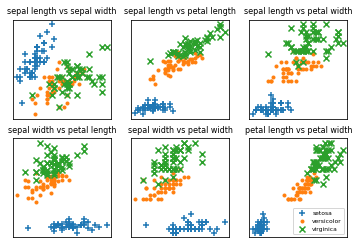

In [39]:
from matplotlib import pyplot as plt 
metrics = ['sepal length', 'sepal width', 'petal length', 'petal width']
pairs = [(i, j) for i in range(4) for j in range(4) if i < j]
marks = ['+', '.', 'x'] #we have 3 classes, so 3 markers

fig, ax = plt.subplots(2, 3)

for row in range(2):
    for col in range(3):
        i, j = pairs[3 * row + col]
        ax[row][col].set_title(f"{metrics[i]} vs {metrics[j]}", fontsize = 8)
        ax[row][col].set_xticks([])
        ax[row][col].set_yticks([])

        for mark, (species, points) in zip(marks, points_by_species.items()):
            xs = [point[i] for point in points]
            ys = [point[j] for point in points]
            ax[row][col].scatter(xs, ys, marker=mark, label=species)

ax[-1][-1].legend(loc='lower right', prop={'size': 6})
plt.show()

In [43]:
#split the data into a test set and a training set
import random
from scratch.machine_learning import split_data

random.seed(12)
iris_train, iris_test = split_data(iris_data, 0.70)

assert len(iris_train) == 0.7 * 150
assert len(iris_test) == 0.3 * 150

In [47]:
'''
    The training set will be the "neighbors" that we'll use to classify the points in the test set. We just need to choose a value for k, the number of neighbors who get to vote. Too small (think k = 1), and we let outliers have too much influence; too large (think k =105), and we just predict the most common class in the dataset.
    In a real application (and with more data), we might create a seperate validation set and use it to choose k. Here we'll just use k = 5
'''

from typing import Tuple

#Track how many times we see (predicted, actual)
confusion_matrix: Dict[Tuple[str, str], int] = defaultdict(int)
num_correct = 0

for iris in iris_test:
    predicted = knn_classify(6, iris_train, iris.point)
    actual = iris.label

    if predicted == actual:
        num_correct += 1

    confusion_matrix[(predicted, actual)] += 1

pct_correct = num_correct / len(iris_test)
print(pct_correct, confusion_matrix)

0.9777777777777777 defaultdict(<class 'int'>, {('setosa', 'setosa'): 13, ('versicolor', 'versicolor'): 15, ('virginica', 'virginica'): 16, ('virginica', 'versicolor'): 1})


In [50]:
#The Curse of Dimensionality

'''
    The k-nearest neighbors algorithm runs into trouble in higher dimensions thanks to the "curse of Dimensionality" which boils down to the fact that high-dimensional spaces are vast. Points are high-dimensional spaces tend not to be close to one another at all. One way to see this is by randomly generating paris fo points in the d-dimensinoal "unit cube" in a variety of dimensions, and calculating the distances between them.
'''

#Generate random points
def random_point(dim: int) -> Vector:
    return [random.random() for _ in range(dim)]

#Function to generate the distances
def random_distances(dim: int, num_pairs: int) -> List[float]:
    return [distance(random_point(dim), random_point(dim)) for _ in range(num_pairs)]

Curse of Dimensionality: 100%|██████████| 100/100 [00:19<00:00,  5.02it/s]


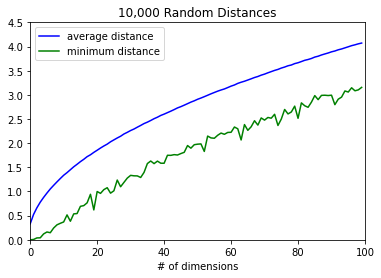

In [65]:
import tqdm
dimensions = range(1, 101)

avg_distance = []
min_distance = []

random.seed(0)
for dim in tqdm.tqdm(dimensions, desc="Curse of Dimensionality"):
    distances = random_distances(dim, 10000)        #10,000 random pairs
    avg_distance.append(sum(distances) / 10000)     #track the avg
    min_distance.append(min(distances))             #track the min

#(Solo) Attempt at graphing data
xs = [i for i, _ in enumerate(dimensions)]
plt.plot(xs, avg_distance, 'b-', label= "average distance")
plt.plot(xs, min_distance, 'g-', label= "minimum distance")

plt.axis([0, 100, 0.0, 4.5])
plt.legend(loc="upper left")
plt.xlabel("# of dimensions")
plt.title("10,000 Random Distances")
plt.show()
#IT WORKED AND DISPLAYED LIKE THE TEXTBOOK

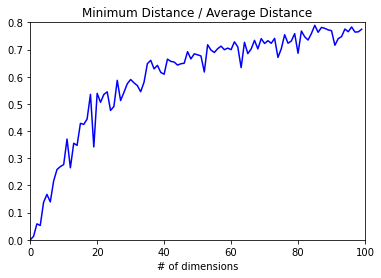

In [67]:
min_avg_ratio = [min_dist / avg_dist for min_dist, avg_dist in zip(min_distance, avg_distance)]

#(Solo)
plt.plot(xs, min_avg_ratio, 'b-')

plt.axis([0, 100, 0.0, 0.8])
plt.xlabel("# of dimensions")
plt.title("Minimum Distance / Average Distance")
plt.show()